In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Import necessary modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

# Import necessary modules from Keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
# Set a random seed for reproducibility
np.random.seed(2)

In [6]:
# Set the style and context for plotting using Seaborn
sns.set(style='white', context='notebook', palette='deep')


In [7]:
# Load the training and test datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [8]:
# Separate the target variable (label) from the training dataset
Y_train = train["label"]

# Drop the 'label' column from the training dataset
X_train = train.drop(labels=["label"], axis=1)

In [9]:
# Normalize the pixel values in the datasets
X_train = X_train / 255.0
test = test / 255.0

In [10]:
# Reshape the training and test datasets to 3 dimensions (height = 28px, width = 28px, channel = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [11]:
# Encode the target variable (label) using one-hot encoding
Y_train = to_categorical(Y_train, num_classes=10)

In [12]:
# Set the random seed for reproducibility
random_seed = 2

In [13]:
# Split the training dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

In [14]:
# Build the CNN model (LeNet architecture)
model_mod = Sequential()
model_mod.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)))
model_mod.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'))
model_mod.add(MaxPool2D(pool_size=(2, 2)))
model_mod.add(Dropout(0.25))
model_mod.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_mod.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_mod.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model_mod.add(Dropout(0.25))
model_mod.add(Flatten())
model_mod.add(Dense(256, activation="relu"))
model_mod.add(Dropout(0.5))
model_mod.add(Dense(10, activation="softmax"))

In [15]:
# Define the optimizer for the model
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

c:\Users\User\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# Compile the model
model_mod.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
# Define a learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [18]:
# Define the number of epochs and batch size for training
epochs = 25
batch_size = 86

In [19]:
# Perform data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)
datagen.fit(X_train)

In [20]:
# Fit the model to the training data with data augmentation
history_gen = model_mod.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)

C:\Users\User\AppData\Local\Temp\ipykernel_6568\4160988207.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_gen = model_mod.fit_generator(


Epoch 1/3
439/439 - 142s - loss: 0.4115 - accuracy: 0.8689 - val_loss: 0.0603 - val_accuracy: 0.9805 - lr: 0.0010 - 142s/epoch - 323ms/step
Epoch 2/3
439/439 - 134s - loss: 0.1241 - accuracy: 0.9636 - val_loss: 0.0468 - val_accuracy: 0.9852 - lr: 0.0010 - 134s/epoch - 306ms/step
Epoch 3/3
439/439 - 134s - loss: 0.0926 - accuracy: 0.9726 - val_loss: 0.0419 - val_accuracy: 0.9871 - lr: 0.0010 - 134s/epoch - 305ms/step


In [21]:
# Evaluate the model on the validation data
print(history_gen.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


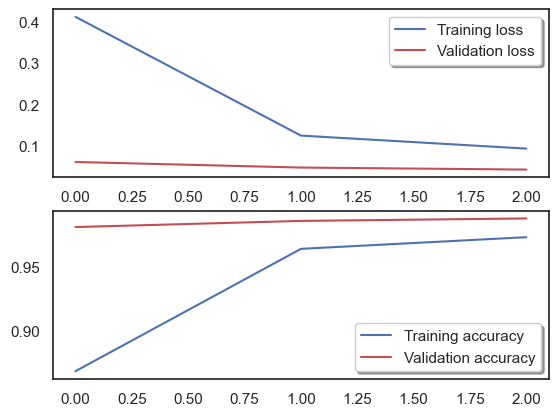

In [22]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1)
ax[0].plot(history_gen.history['loss'], color='b', label="Training loss")
ax[0].plot(history_gen.history['val_loss'], color='r', label="Validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)
ax[1].plot(history_gen.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history_gen.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


132/132 [==============================] - 6s 40ms/step


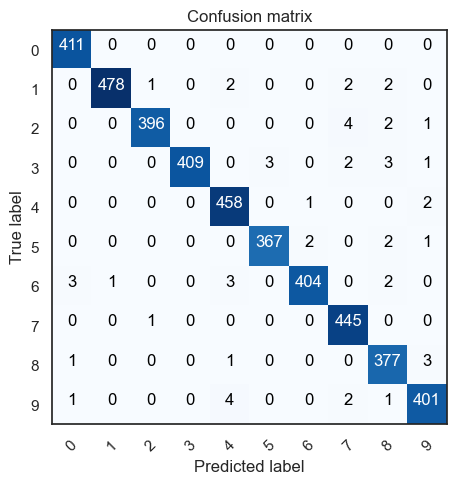

In [23]:
# Compute and plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the labels for the validation dataset
Y_pred = model_mod.predict(X_val)
# Convert predictions to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation labels to class labels
Y_true = np.argmax(Y_val, axis=1)
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(10))

In [24]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       411
           1       1.00      0.99      0.99       485
           2       0.99      0.98      0.99       403
           3       1.00      0.98      0.99       418
           4       0.98      0.99      0.99       461
           5       0.99      0.99      0.99       372
           6       0.99      0.98      0.99       413
           7       0.98      1.00      0.99       446
           8       0.97      0.99      0.98       382
           9       0.98      0.98      0.98       409

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



In [32]:
model_mod.save('model.h5')

In [ ]:
# !tensorflowjs_converter --input_format keras model.h5 tfjs_model # Convert to tensorflow.js model in Terminal